<a href="https://colab.research.google.com/github/aymenchibouti/newversion/blob/master/transformers_model_res.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Load the data
data = pd.read_csv('model1_210_features_spliting.csv')

# Preprocessing
# Separate features and target
X = data.drop(['enrollment_id', 'username', 'course_id', 'dropout'], axis=1).values
y = data['dropout'].values

# Reshape data for transformer (samples, time_steps, features)
# We have 30 days and 7 features per day
X = X.reshape(X.shape[0], 30, 7)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize the data (per feature)
scaler = StandardScaler()
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

# Transformer Model Architecture
def build_transformer_model(input_shape, head_size=32, num_heads=4, ff_dim=64, num_transformer_blocks=4, mlp_units=[64], dropout=0.1, mlp_dropout=0.1):
    inputs = keras.Input(shape=input_shape)

    # Create positional embeddings
    positions = tf.range(start=0, limit=input_shape[0], delta=1)
    position_embedding = layers.Embedding(input_dim=input_shape[0], output_dim=input_shape[1])(positions)

    # Combine input with positional embeddings
    x = inputs + position_embedding

    for _ in range(num_transformer_blocks):
        # Normalization and Attention
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=head_size, dropout=dropout
        )(x1, x1)
        x2 = layers.Add()([attention_output, x])

        # Feed Forward Part
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dense(ff_dim, activation="relu")(x3)
        x3 = layers.Dense(input_shape[1])(x3)
        x = layers.Add()([x3, x2])

    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # MLP for classification
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

# Model parameters
input_shape = (30, 7)  # 30 days, 7 features per day
model = build_transformer_model(
    input_shape,
    head_size=32,
    num_heads=4,
    ff_dim=64,
    num_transformer_blocks=4,
    mlp_units=[64],
    dropout=0.2,
    mlp_dropout=0.2
)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Add callbacks
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)
]

# Train the model
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    class_weight={0: 1, 1: 2}  # Adjust for class imbalance if needed
)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
y_pred_class = (y_pred > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Epoch 1/100
965/965 ━━━━━━━━━━━━━━━━━━━━ 72s 61ms/step - accuracy: 0.8433 - loss: 0.4870 - val_accuracy: 0.8543 - val_loss: 0.3646 - learning_rate: 0.0010
Epoch 2/100
965/965 ━━━━━━━━━━━━━━━━━━━━ 80s 60ms/step - accuracy: 0.8560 - loss: 0.4546 - val_accuracy: 0.8603 - val_loss: 0.3626 - learning_rate: 0.0010
Epoch 3/100
965/965 ━━━━━━━━━━━━━━━━━━━━ 81s 58ms/step - accuracy: 0.8578 - loss: 0.4475 - val_accuracy: 0.8583 - val_loss: 0.3611 - learning_rate: 0.0010
Epoch 4/100
965/965 ━━━━━━━━━━━━━━━━━━━━ 56s 58ms/step - accuracy: 0.8615 - loss: 0.4405 - val_accuracy: 0.8581 - val_loss: 0.3749 - learning_rate: 0.0010
Epoch 5/100
965/965 ━━━━━━━━━━━━━━━━━━━━ 83s 59ms/step - accuracy: 0.8628 - loss: 0.4400 - val_accuracy: 0.8556 - val_loss: 0.3664 - learning_rate: 0.0010
Epoch 6/100
965/965 ━━━━━━━━━━━━━━━━━━━━ 82s 59ms/step - accuracy: 0.8566 - loss: 0.4513 - val_accuracy: 0.8656 - val_loss: 0.3489 - learning_rate: 0.0010
Epoch 7/100
965/965 ━━━━━━━━━━━━━━━━━━━━ 82s 60ms/step - accuracy: 0.8

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score,
                           recall_score, f1_score, roc_auc_score,
                           confusion_matrix, classification_report, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Load and prepare data
data = pd.read_csv('model1_210_features_spliting.csv')
X = data.drop(['enrollment_id', 'username', 'course_id', 'dropout'], axis=1).values
y = data['dropout'].values

# Reshape and split data
X = X.reshape(X.shape[0], 30, 7)  # 30 days, 7 features per day
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance with SMOTE
X_train_flat = X_train.reshape(X_train.shape[0], -1)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_flat, y_train)
X_train_smote = X_train_smote.reshape(-1, 30, 7)

# Normalization
scaler = StandardScaler()
X_train_reshaped = X_train_smote.reshape(-1, X_train_smote.shape[-1])
X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(X_train_smote.shape)
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

## Fixed Enhanced Transformer Model
class PositionalEncoding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def build(self, input_shape):
        self.position_embedding = layers.Embedding(
            input_dim=self.sequence_length,
            output_dim=self.output_dim,
            embeddings_initializer="glorot_uniform")

    def call(self, inputs):
        positions = tf.range(start=0, limit=self.sequence_length, delta=1)
        positions = tf.expand_dims(positions, axis=0)  # Add batch dimension
        return self.position_embedding(positions)

def build_enhanced_transformer(input_shape, head_size=64, num_heads=4,
                             ff_dim=128, num_transformer_blocks=4,
                             mlp_units=[128, 64], dropout=0.2, mlp_dropout=0.3):
    inputs = keras.Input(shape=input_shape)

    # Feature Embedding
    x = layers.Dense(head_size, activation="relu")(inputs)

    # Positional Encoding
    pos_encoding = PositionalEncoding(
        sequence_length=input_shape[0],
        output_dim=head_size)(inputs)

    # Combine feature and positional embeddings
    x = layers.Add()([x, pos_encoding])

    # Transformer Blocks
    for _ in range(num_transformer_blocks):
        # Normalization and Attention
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=head_size//num_heads,
            dropout=dropout)(x1, x1)
        x = layers.Add()([attention_output, x])

        # Feed Forward Network
        x2 = layers.LayerNormalization(epsilon=1e-6)(x)
        x2 = layers.Dense(ff_dim)(x2)
        x2 = layers.Activation('gelu')(x2)
        x2 = layers.Dense(head_size)(x2)
        x = layers.Add()([x2, x])

    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # MLP Head
    for dim in mlp_units:
        x = layers.Dense(dim)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('gelu')(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

# Build model
input_shape = (30, 7)
model = build_enhanced_transformer(
    input_shape,
    head_size=64,
    num_heads=4,
    ff_dim=128,
    num_transformer_blocks=4,
    mlp_units=[128, 64],
    dropout=0.2,
    mlp_dropout=0.3
)

# Learning rate schedule
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate):
        self.initial_learning_rate = initial_learning_rate

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        lr = tf.cond(
            step < 1000,
            lambda: self.initial_learning_rate,
            lambda: tf.cond(
                step < 3000,
                lambda: self.initial_learning_rate * 0.5,
                lambda: self.initial_learning_rate * 0.1
            )
        )
        return lr

# Focal loss for class imbalance
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -tf.reduce_mean(alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt))
        return loss
    return focal_loss_fn

model.compile(
    optimizer=keras.optimizers.AdamW(LRSchedule(1e-3)),
    loss=focal_loss(),
    metrics=["accuracy",
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             keras.metrics.AUC(name='auc')]
)

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        patience=15,
        restore_best_weights=True,
        monitor='val_auc',
        mode='max'
    ),
    keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        save_best_only=True,
        monitor='val_auc',
        mode='max'
    )
]

# Train with class weights
class_weight = {0: 1, 1: 1.5}
history = model.fit(
    X_train_scaled,
    y_train_smote,
    validation_split=0.15,
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=1
)

## Visualization Functions
def plot_training_history(history):
    plt.figure(figsize=(18, 6))

    # Accuracy
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # AUC
    plt.subplot(1, 3, 3)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Continue', 'Dropout'],
                yticklabels=['Continue', 'Dropout'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = roc_auc_score(y_true, y_pred_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

## Evaluation
y_pred_prob = model.predict(X_test_scaled).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualizations
plot_training_history(history)
plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(y_test, y_pred_prob)

Epoch 1/100
813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.7612 - auc: 0.7980 - loss: 0.0476 - precision: 0.7592 - recall: 0.8673

NotImplementedError: Learning rate schedule 'LRSchedule' must override `get_config()` in order to be serializable.

Epoch 1/100
813/813 ━━━━━━━━━━━━━━━━━━━━ 156s 166ms/step - accuracy: 0.7633 - auc: 0.8031 - loss: 0.0478 - precision: 0.7594 - recall: 0.8705 - val_accuracy: 0.2485 - val_auc: 0.0000e+00 - val_loss: 0.2166 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
813/813 ━━━━━━━━━━━━━━━━━━━━ 142s 166ms/step - accuracy: 0.8004 - auc: 0.8402 - loss: 0.0391 - precision: 0.7925 - recall: 0.8992 - val_accuracy: 0.7058 - val_auc: 0.0000e+00 - val_loss: 0.0302 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
813/813 ━━━━━━━━━━━━━━━━━━━━ 139s 162ms/step - accuracy: 0.8026 - auc: 0.8528 - loss: 0.0377 - precision: 0.7935 - recall: 0.8994 - val_accuracy: 0.9999 - val_auc: 0.0000e+00 - val_loss: 0.0088 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
813/813 ━━━━━━━━━━━━━━━━━━━━ 144s 164ms/step - accuracy: 0.8074 - auc: 0.8540 - loss: 0.0375 - precision: 0.7956 - recall: 0.9069 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0068 - val_precision: 

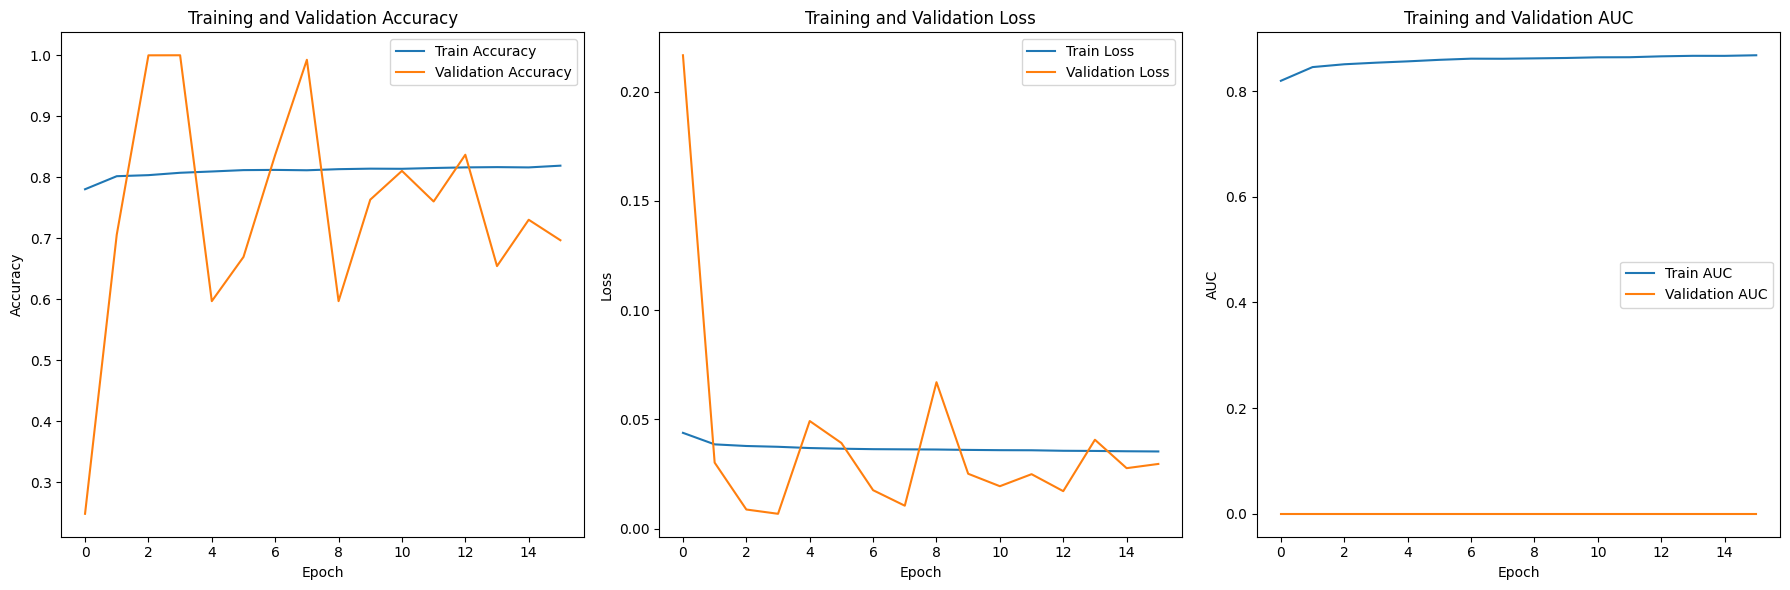

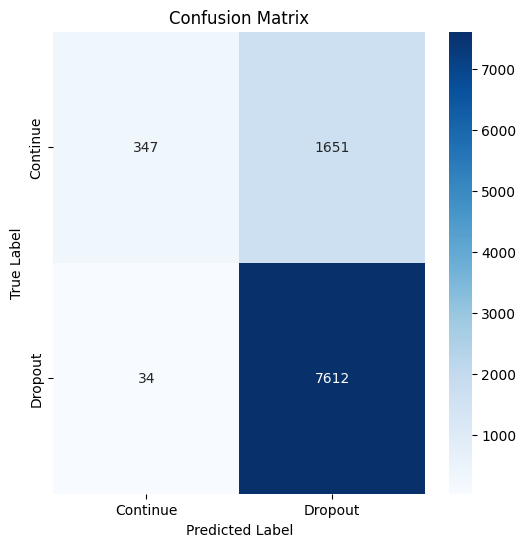

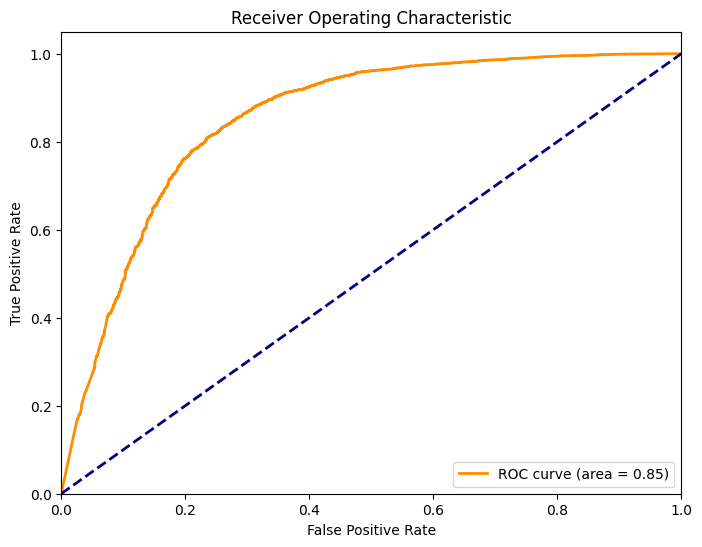

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score,
                           recall_score, f1_score, roc_auc_score,
                           confusion_matrix, classification_report, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Load and prepare data
data = pd.read_csv('model1_210_features_spliting.csv')
X = data.drop(['enrollment_id', 'username', 'course_id', 'dropout'], axis=1).values
y = data['dropout'].values

# Reshape and split data
X = X.reshape(X.shape[0], 30, 7)  # 30 days, 7 features per day
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance with SMOTE
X_train_flat = X_train.reshape(X_train.shape[0], -1)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_flat, y_train)
X_train_smote = X_train_smote.reshape(-1, 30, 7)

# Normalization
scaler = StandardScaler()
X_train_reshaped = X_train_smote.reshape(-1, X_train_smote.shape[-1])
X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(X_train_smote.shape)
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

# Enhanced Transformer Model with fixed LRSchedule
class PositionalEncoding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def build(self, input_shape):
        self.position_embedding = layers.Embedding(
            input_dim=self.sequence_length,
            output_dim=self.output_dim,
            embeddings_initializer="glorot_uniform")

    def call(self, inputs):
        positions = tf.range(start=0, limit=self.sequence_length, delta=1)
        positions = tf.expand_dims(positions, axis=0)  # Add batch dimension
        return self.position_embedding(positions)

class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate):
        super().__init__()
        self.initial_learning_rate = initial_learning_rate

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        lr = tf.cond(
            step < 1000,
            lambda: self.initial_learning_rate,
            lambda: tf.cond(
                step < 3000,
                lambda: self.initial_learning_rate * 0.5,
                lambda: self.initial_learning_rate * 0.1
            )
        )
        return lr

    def get_config(self):
        return {'initial_learning_rate': self.initial_learning_rate}

def build_enhanced_transformer(input_shape, head_size=64, num_heads=4,
                             ff_dim=128, num_transformer_blocks=4,
                             mlp_units=[128, 64], dropout=0.2, mlp_dropout=0.3):
    inputs = keras.Input(shape=input_shape)

    # Feature Embedding
    x = layers.Dense(head_size, activation="relu")(inputs)

    # Positional Encoding
    pos_encoding = PositionalEncoding(
        sequence_length=input_shape[0],
        output_dim=head_size)(inputs)

    # Combine feature and positional embeddings
    x = layers.Add()([x, pos_encoding])

    # Transformer Blocks
    for _ in range(num_transformer_blocks):
        # Normalization and Attention
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=head_size//num_heads,
            dropout=dropout)(x1, x1)
        x = layers.Add()([attention_output, x])

        # Feed Forward Network
        x2 = layers.LayerNormalization(epsilon=1e-6)(x)
        x2 = layers.Dense(ff_dim)(x2)
        x2 = layers.Activation('gelu')(x2)
        x2 = layers.Dense(head_size)(x2)
        x = layers.Add()([x2, x])

    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # MLP Head
    for dim in mlp_units:
        x = layers.Dense(dim)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('gelu')(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

# Build model
input_shape = (30, 7)
model = build_enhanced_transformer(
    input_shape,
    head_size=64,
    num_heads=4,
    ff_dim=128,
    num_transformer_blocks=4,
    mlp_units=[128, 64],
    dropout=0.2,
    mlp_dropout=0.3
)

# Focal loss for class imbalance
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -tf.reduce_mean(alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt))
        return loss
    return focal_loss_fn

model.compile(
    optimizer=keras.optimizers.AdamW(LRSchedule(1e-3)),
    loss=focal_loss(),
    metrics=["accuracy",
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             keras.metrics.AUC(name='auc')]
)

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        patience=15,
        restore_best_weights=True,
        monitor='val_auc',
        mode='max'
    ),
    keras.callbacks.ModelCheckpoint(
        'best_model.keras',  # Changed to .keras format
        save_best_only=True,
        monitor='val_auc',
        mode='max'
    )
]

# Train with class weights
class_weight = {0: 1, 1: 1.5}
history = model.fit(
    X_train_scaled,
    y_train_smote,
    validation_split=0.15,
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=1
)

## Visualization Functions
def plot_training_history(history):
    plt.figure(figsize=(18, 6))

    # Accuracy
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # AUC
    plt.subplot(1, 3, 3)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Continue', 'Dropout'],
                yticklabels=['Continue', 'Dropout'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = roc_auc_score(y_true, y_pred_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

## Evaluation
y_pred_prob = model.predict(X_test_scaled).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualizations
plot_training_history(history)
plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(y_test, y_pred_prob)